**Since the previous dataset performed poorly in fraud detection, our teammate attempted to improve the results by tuning the parameters of the XGBoost model. However, the adjustments did not yield significant improvements. Upon rechecking the dataset, he confirmed my earlier suspicion from a previous code version: the similarities between fraudulent and non-fraudulent transactions are too strong, making it difficult for the models to differentiate between them. To address this issue, an updated dataset has been provided by the teammate, who verified the problem. After the data is preproceesed again by abother group member, I will now apply the same methodologies for training and evaluation, with a final conclusion presented at the end of the process.**

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from collections import defaultdict
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split


In [8]:
df = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/project final/new_dataset.csv")

In [9]:
df.head()

,Gender,Age,State,City,Bank_Branch,Account_Type,Transaction_Amount,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Transaction_Description,Transaction_Month,Transaction_Day,Transaction_Weekday,Time_Category
0,Male,25,CA,Los Angeles,Branch B,Checking,102.690676,Online,Clothing,1760.420524,POS Terminal,CA,Windows PC,0,USD,Gift,1,1,6,Night
1,Female,58,FL,New York,Branch C,Savings,83.034624,ATM Withdrawal,Luxury,7833.088780,Web,TX,Android,0,USD,Payment,1,1,6,Night
2,Female,71,PA,Dallas,Branch A,Savings,51.521278,ATM Withdrawal,Travel,7239.890561,POS Terminal,IL,Windows PC,0,EUR,Subscription,1,1,6,Night
3,Female,27,NY,Chicago,Branch A,Savings,74.897156,ATM Withdrawal,Clothing,4269.744125,POS Terminal,CA,Windows PC,0,CAD,Subscription,1,1,6,Night
4,Male,28,OH,Philadelphia,Branch B,Savings,5.000000,Online,Electronics,4877.511195,Web,PA,Linux,0,CAD,Gift,1,1,6,Night


## Load train and test sets

In [2]:
train = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/project final/processed_train_set.csv")
test = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/project final/processed_test_set.csv")

In [3]:
train.columns

Index(['Transaction_Amount', 'Merchant_Category', 'Transaction_Location',
       'Device_Type', 'Transaction_Month', 'Transaction_Day',
       'Transaction_Device_Mobile', 'Transaction_Device_POS Terminal',
       'Is_Fraud'],
      dtype='object')

In [4]:
X_train = train.drop(columns='Is_Fraud')
y_train = train['Is_Fraud']
X_test = test.drop(columns='Is_Fraud')
y_test = test['Is_Fraud']

## Apply SMOTETomek

In [5]:
smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)


In [6]:
df_resampled = pd.DataFrame(X_resampled, columns=train.columns) ## features train
df_resampled['Is_Fraud'] = y_resampled ## Target y
print(df_resampled['Is_Fraud'].value_counts())


Is_Fraud
0    148800
1     74400
Name: count, dtype: int64


## Models and Performance Metrics

In [7]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,  confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, classification_report, auc
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
import matplotlib.pyplot as plt

In [8]:
def modelling(X_train, y_train, X_test,y_test):

    ## Define the models
    models  = {
        'Logistic Regression': LogisticRegression(),
        'XBGoost': xgb.XGBClassifier(random_state =42),
        'Light GBM': lgb.LGBMClassifier(class_weight='balanced', random_state= 42),
        'KNeighbors': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Stacking Ensemble': StackingClassifier(
            estimators=[
                ('xgb', xgb.XGBClassifier( random_state=42)),
                ('lgb', lgb.LGBMClassifier( class_weight='balanced', random_state=42)),
            ],
            final_estimator=LogisticRegression(),
            stack_method='predict_proba')
    }

    ## Define the performance metrics
    results = []
    for model_name, model in models.items():
        print(f"\n🔹 Training {model_name}...\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Used for ROC Curve
        
        ## The binary classification problem actually contains the following performance metrics
        roc_auc = np.round(roc_auc_score(y_test, y_prob), 4)  ## ROC score
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = np.round(report["accuracy"], 4) 
        precision = np.round(report["1"]["precision"], 4) ## For classifed to Fraud
        recall = np.round(report["1"]["recall"], 4)  ## For classifed to Fraud
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
        f1_score = np.round(report["1"]["f1-score"], 4)

        results.append({
            "Model": model_name,
            "ROC-AUC Score": roc_auc,
            "Accuracy": accuracy,
            "Precision (Fraud)": precision,
            "Recall (Fraud)": recall,
            "F1 Score (Fraud)": f1_score
        })

    plt.figure(figsize=(10, 5))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Fraud Detection Models")
    plt.legend()
    plt.grid()
    plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df



## Train and evaluate the model


🔹 Training Logistic Regression...


🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74400, number of negative: 148800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 223200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

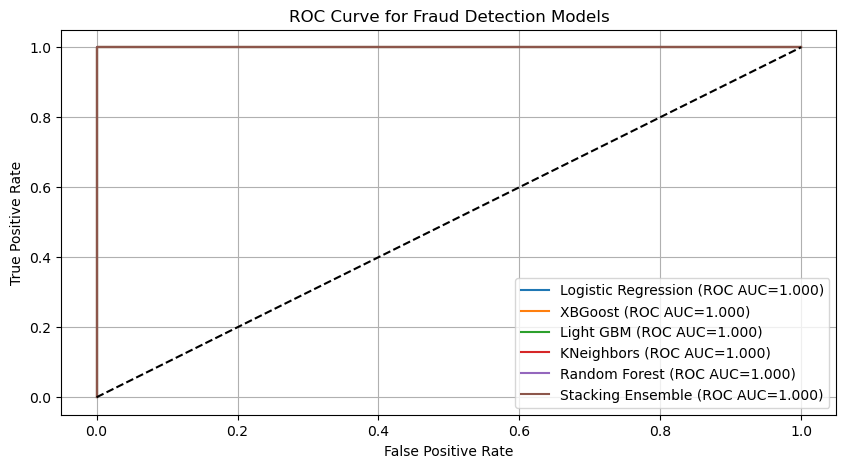

In [9]:
evaluation = modelling(X_resampled, y_resampled, X_test, y_test)

In [10]:
evaluation

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,1.0,1.0,1.0,1.0,1.0
1,XBGoost,1.0,1.0,1.0,1.0,1.0
2,Light GBM,1.0,1.0,1.0,1.0,1.0
3,KNeighbors,1.0,1.0,1.0,1.0,1.0
4,Random Forest,1.0,1.0,1.0,1.0,1.0
5,Stacking Ensemble,1.0,1.0,1.0,1.0,1.0


In [11]:
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_resampled,y_resampled)
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Convert to a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    "Feature": X_resampled.columns,
    "Importance": feature_importances
})

# Sort by importance (highest to lowest)
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)


In [12]:
feature_importance_df

,Feature,Importance
0,Transaction_Amount,0.411554
4,Transaction_Month,0.307457
1,Merchant_Category,0.119798
5,Transaction_Day,0.094211
2,Transaction_Location,0.036776
6,Transaction_Device_Mobile,0.014818
7,Transaction_Device_POS Terminal,0.011599
3,Device_Type,0.003788


In [13]:
## Select features with greater than 0.04 importance
threshold = 0.003
selected_features = feature_importance_df[feature_importance_df["Importance"] > threshold]["Feature"].tolist()

In [14]:
## Refine x_resample and x_test
X_resampled_selected = X_resampled[selected_features]
X_test_selected = X_test[selected_features]


🔹 Training Logistic Regression...


🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 74400, number of negative: 148800
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 223200, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

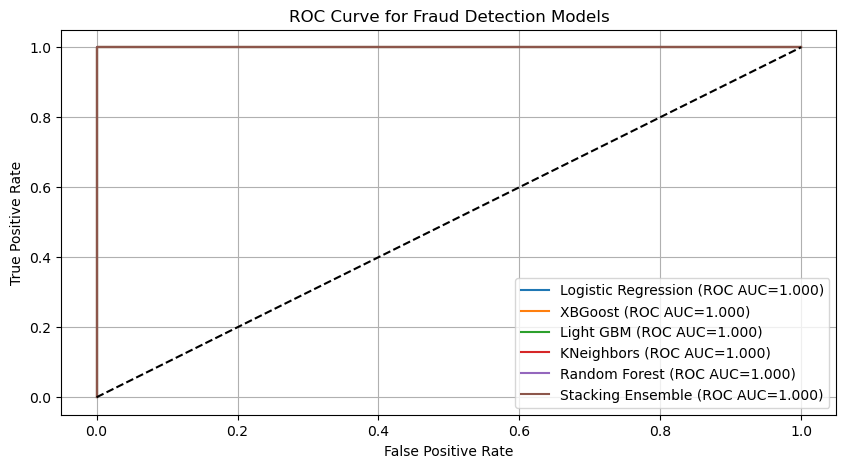

In [15]:
## Use selected features to train the model
results_selected = modelling(X_resampled_selected,y_resampled, X_test_selected, y_test)

In [33]:
results_selected

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,1.0,1.0,1.0,1.0,1.0
1,XBGoost,1.0,1.0,1.0,1.0,1.0
2,Light GBM,1.0,1.0,1.0,1.0,1.0
3,KNeighbors,1.0,1.0,1.0,1.0,1.0
4,Random Forest,1.0,1.0,1.0,1.0,1.0
5,Stacking Ensemble,1.0,1.0,1.0,1.0,1.0


## Feature Engineering

In [16]:
data = pd.read_csv("C:/Users/zhao2/OneDrive/Desktop/MMA Courses/INSY 695/Bank_Transaction_Fraud_Detection.csv")

In [17]:
df_copy = train
df_copy2 = test

In [ ]:
df_copy["amount_to_avg_ratio"] = data["Transaction_Amount"] / data.groupby("Customer_ID")["Transaction_Amount"].transform("mean")
df_copy2["amount_to_avg_ratio"] = data["Transaction_Amount"] / data.groupby("Customer_ID")["Transaction_Amount"].transform("mean")

In [ ]:
df_copy["transactions_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_ID"].transform("count")
df_copy["unique_merchants"] = data.groupby("Customer_ID")["Merchant_ID"].transform("nunique")
df_copy2["transactions_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_ID"].transform("count")
df_copy2["unique_merchants"] = data.groupby("Customer_ID")["Merchant_ID"].transform("nunique")

In [ ]:
df_copy["average_spending_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_Amount"].transform("mean")
df_copy["spending_change"] = df_copy["Transaction_Amount"] / df_copy["average_spending_per_day"]
df_copy2["average_spending_per_day"] = data.groupby(["Customer_ID", "Transaction_Date"])["Transaction_Amount"].transform("mean")
df_copy2["spending_change"] = df_copy["Transaction_Amount"] / df_copy["average_spending_per_day"]

In [21]:
df_copy2.head()

,Transaction_Amount,Merchant_Category,Transaction_Location,Device_Type,Transaction_Month,Transaction_Day,Transaction_Device_Mobile,Transaction_Device_POS Terminal,Is_Fraud,amount_to_avg_ratio,transactions_per_day,unique_merchants,average_spending_per_day,spending_change
0,3.998162,4,1,3,3,22,False,False,0,1.0,1,1,32415.45,0.000136
1,4.222577,5,1,1,3,30,False,False,0,1.0,1,1,43622.60,0.000099
2,4.412526,4,4,2,5,1,False,True,0,1.0,1,1,63062.56,0.000069
3,4.193827,3,0,1,3,1,False,False,0,1.0,1,1,14000.72,0.000450
4,3.472688,3,4,0,5,3,False,False,0,1.0,1,1,18335.16,0.000239


## Train and evaluate the models again

In [22]:
X_train = df_copy.drop(columns='Is_Fraud')
y_train = df_copy['Is_Fraud']
X_test = df_copy2.drop(columns='Is_Fraud')
y_test = df_copy2['Is_Fraud']

In [23]:
smote_tomek = SMOTETomek(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
df_resampled = pd.DataFrame(X_resampled, columns=df_copy.columns) ## features df_copy
df_resampled['Is_Fraud'] = y_resampled ## Target y
print(df_resampled['Is_Fraud'].value_counts())

Is_Fraud
0    148291
1     73891
Name: count, dtype: int64


In [25]:
def modelling(X_train, y_train, X_test,y_test):

    ## Define the models
    models  = {
        'Logistic Regression': LogisticRegression(),
        'XBGoost': xgb.XGBClassifier(random_state =42),
        'Light GBM': lgb.LGBMClassifier(class_weight='balanced', random_state= 42),
        'KNeighbors': KNeighborsClassifier(),
        'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
        'Stacking Ensemble': StackingClassifier(
            estimators=[
                ('xgb', xgb.XGBClassifier( random_state=42)),
                ('lgb', lgb.LGBMClassifier( class_weight='balanced', random_state=42)),
            ],
            final_estimator=LogisticRegression(),
            stack_method='predict_proba')
    }

    ## Define the performance metrics
    results = []
    for model_name, model in models.items():
        print(f"\n🔹 Training {model_name}...\n")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]  # Used for ROC Curve
        
        ## The binary classification problem actually contains the following performance metrics
        roc_auc = np.round(roc_auc_score(y_test, y_prob), 4)  ## ROC score
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = np.round(report["accuracy"], 4) 
        precision = np.round(report["1"]["precision"], 4) ## For classifed to Fraud
        recall = np.round(report["1"]["recall"], 4)  ## For classifed to Fraud
        
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_vals, precision_vals)
        f1_score = np.round(report["1"]["f1-score"], 4)

        results.append({
            "Model": model_name,
            "ROC-AUC Score": roc_auc,
            "Accuracy": accuracy,
            "Precision (Fraud)": precision,
            "Recall (Fraud)": recall,
            "F1 Score (Fraud)": f1_score
        })

    plt.figure(figsize=(10, 5))
    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{model_name} (ROC AUC={roc_auc:.3f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Fraud Detection Models")
    plt.legend()
    plt.grid()
    plt.show()
    
    results_df = pd.DataFrame(results)
    return results_df




🔹 Training Logistic Regression...



c:\Users\zhao2\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



🔹 Training XBGoost...


🔹 Training Light GBM...

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 73891, number of negative: 148291
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 829
[LightGBM] [Info] Number of data points in the train set: 222182, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

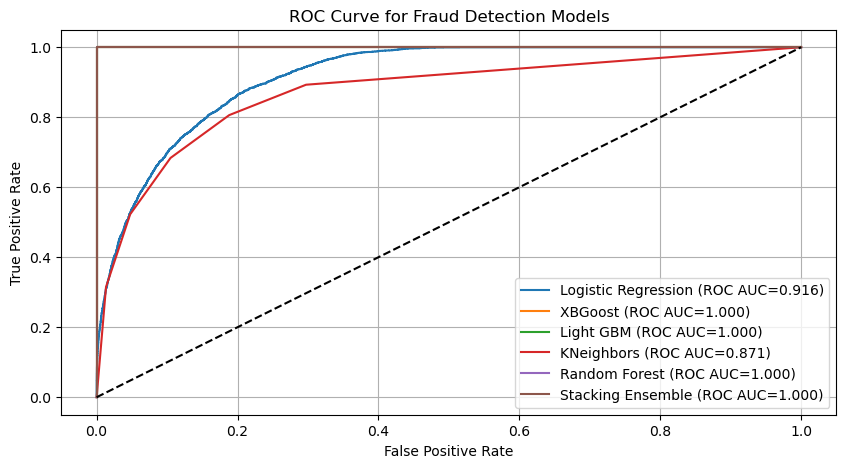

,Model,ROC-AUC Score,Accuracy,Precision (Fraud),Recall (Fraud),F1 Score (Fraud)
0,Logistic Regression,0.9163,0.8605,0.3022,0.7582,0.4321
1,XBGoost,1.0000,1.0000,1.0000,1.0000,1.0000
2,Light GBM,1.0000,1.0000,1.0000,1.0000,1.0000
3,KNeighbors,0.8708,0.8804,0.3293,0.6836,0.4444
4,Random Forest,1.0000,1.0000,1.0000,1.0000,1.0000
5,Stacking Ensemble,1.0000,1.0000,1.0000,1.0000,1.0000


In [26]:
modelling(X_resampled, y_resampled, X_test, y_test)

In [27]:
from sklearn.metrics import precision_recall_curve

## We will switch the X_resample and y_resample  to the original ones using the train and test sets
model = xgb.XGBClassifier(random_state =42)
model.fit(X_resampled, y_resampled)
y_probs = model.predict_proba(X_test)[:, 1] 
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
optimal_threshold = thresholds[recall.argmax()]  # Choose threshold maximizing recall

y_pred_adjusted = (y_probs > optimal_threshold).astype(int)


In [28]:
roc_auc = roc_auc_score(y_test, y_probs)

# Print Performance Metrics
print(f"🔹 ROC-AUC Score: {roc_auc:.4f}")
print("🔹 Classification Report:\n", classification_report(y_test, y_pred_adjusted))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_adjusted)
print("🔹 Confusion Matrix:\n", conf_matrix)


🔹 ROC-AUC Score: 1.0000
🔹 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37200
           1       1.00      1.00      1.00      2800

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000

🔹 Confusion Matrix:
 [[37200     0]
 [    0  2800]]


## Save the model and the notebook to github.

In [29]:
xgb_model = xgb.XGBClassifier(random_state =42)


In [31]:
import pickle
with open("xgb_fraud_model.pkl","wb") as f:
    pickle.dump(xgb_model, f)


In [55]:
import pickle
with open("lightgbm_fraud_model.pkl", "wb") as f:
    pickle.dump(xgb_model, f)

##  Conclusion:  
* The initial evaluation of six machine learning models—Logistic Regression, XGBoost, LightGBM, K-Nearest Neighbors (KNN), Random Forest, and a Stacking Ensemble—yielded perfect results. All models achieved an ROC-AUC score of 1.0, along with 100% accuracy, precision, recall, and F1-score. These results indicate that the models completely distinguished fraudulent and non-fraudulent transactions without error. However, such perfect scores suggest potential data leakage or an overly simplified dataset.
* After applying feature selection using Random Forest, the models still achieved perfect scores across all metrics. This suggests that redundant or non-informative features were successfully removed without negatively impacting performance. However, the continued 100% performance across all models raises concerns about data leakage again. 
* With feature engineering applied, the results suggest that feature engineering introduced a challenge for simpler models like Logistic Regression and KNN, making them less effective at identifying fraudulent transactions. However, more complex models (e.g., XGBoost, Random Forest) remained highly effective.

**Potential Probelm:**  
* The consistently perfect scores (100% accuracy, precision, recall, and ROC-AUC) in the first two evaluations strongly suggest data leakage, meaning certain features may unintentionally expose fraud labels, resulting in artificially inflated performance.  
* Highly complex models like XGBoost and Random Forest achieving flawless results on both training and test data indicate a risk of memorization rather than true generalization.  
* A deeper analysis is required to determine whether the models are genuinely learning meaningful fraud detection patterns or simply exploiting artifacts within the dataset.

## Autoencoder

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

In [11]:
# Define features and target
X = df.drop(columns=["Is_Fraud"])  # Features
y = df["Is_Fraud"]  # Target variable

In [ ]:
categorical_cols = ['Gender', 'Account_Type', 'Device_Type', 'Time_Category', 'Transaction_Type',
                    'Merchant_Category', 'Transaction_Device', 'State', 'City', 'Bank_Branch',
                    'Transaction_Location', 'Transaction_Description']

# Define different encoding strategies
one_hot_cols = ['Gender', 'Account_Type', 'Transaction_Type']  
label_cols = ['Time_Category']  
freq_cols = ['Device_Type', 'Transaction_Device', 'State', 'City', 'Bank_Branch'] 
target_cols = ['Merchant_Category', 'Transaction_Location', 'Transaction_Description']  

# Separate features and target variable
X = df.drop(columns=["Is_Fraud"])
y = df["Is_Fraud"]

# Apply one-hot encoding
X = pd.get_dummies(X, columns=one_hot_cols, drop_first=True)

# Apply label encoding
le = LabelEncoder()
for col in label_cols:
    X[col] = le.fit_transform(X[col])

# Apply frequency encoding
for col in freq_cols:
    freq_map = X[col].value_counts().to_dict()
    X[col] = X[col].map(freq_map)

# Apply target encoding
te = TargetEncoder()
X[target_cols] = te.fit_transform(X[target_cols], y)


,Age,State,City,Bank_Branch,Transaction_Amount,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,...,Transaction_Description,Transaction_Month,Transaction_Day,Transaction_Weekday,Time_Category,Gender_1,Account_Type_1,Account_Type_2,Transaction_Type_1,Transaction_Type_2
0,0.114754,28538,28507,49849,0.051610,0,0.129140,46436,0,38104,...,1,0.0,0.0,1.0,3,True,True,False,True,False
1,0.655738,28648,28448,50027,0.041226,3,0.574615,53687,8,31016,...,2,0.0,0.0,1.0,3,False,False,True,False,False
2,0.868852,28496,28578,50274,0.024577,5,0.531099,46436,3,38104,...,4,0.0,0.0,1.0,3,False,False,True,False,False
3,0.147541,28613,28762,50274,0.036927,0,0.313217,46436,0,38104,...,4,0.0,0.0,1.0,3,False,False,True,False,False
4,0.163934,28631,28583,49849,0.000000,1,0.357801,53687,7,30969,...,1,0.0,0.0,1.0,3,True,False,True,True,False


In [17]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train-test (Train on Normal Transactions Only)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Select only Non-Fraud transactions for Autoencoder Training
X_train_normal = X_train[y_train == 0]  

In [18]:
input_dim = X_train_normal.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu")(input_layer)
encoded = Dense(8, activation="relu")(encoded)
encoded = Dense(4, activation="relu")(encoded)

decoded = Dense(8, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(decoded)
decoded = Dense(input_dim, activation="sigmoid")(decoded) 

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer="adam", loss="mse") 


In [19]:
autoencoder.fit(X_train_normal, X_train_normal, epochs=50, batch_size=32, shuffle=True, validation_split=0.1, verbose=1)


Epoch 1/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 0.8865 - val_loss: 0.7875
Epoch 2/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.7807 - val_loss: 0.7741
Epoch 3/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.7701 - val_loss: 0.7686
Epoch 4/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.7648 - val_loss: 0.7657
Epoch 5/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.7630 - val_loss: 0.7645
Epoch 6/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.7625 - val_loss: 0.7645
Epoch 7/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.7614 - val_loss: 0.7630
Epoch 8/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.7595 - val_loss: 0.7600
Epoch 9/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.7582 - val_loss: 0.7597
Epoch 10/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.7578 - val_loss: 0.7594
Epoch 11/50
4184/4184 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.7566 - val_loss: 0.7595
Epoch 12/50
4184/4184 ━━━━

In [20]:
X_test_reconstructed = autoencoder.predict(X_test)
reconstruction_errors = np.mean(np.abs(X_test - X_test_reconstructed), axis=1)

threshold = np.percentile(reconstruction_errors, 95)

y_pred_autoencoder = (reconstruction_errors > threshold).astype(int)


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1s 539us/step


In [21]:
roc_auc = roc_auc_score(y_test, y_pred_autoencoder)
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")

print("🔹 Classification Report:\n", classification_report(y_test, y_pred_autoencoder))


🔹 ROC AUC Score: 0.6962
🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     37236
           1       0.57      0.42      0.48      2764

    accuracy                           0.94     40000
   macro avg       0.77      0.70      0.72     40000
weighted avg       0.93      0.94      0.93     40000



## Summary:  
*The autoencoder fraud detection model demonstrates moderate performance with a ROC AUC score of 0.6962, indicating that its ability to distinguish between fraudulent and non-fraudulent transactions is limited. The precision for fraud detection is 0.57, meaning that 57% of predicted fraud cases are truly fraudulent, while the recall is 0.42, indicating that the model only captures 42% of actual fraud cases. This results in an F1-score of 0.48, highlighting an imbalance between precision and recall. Its struggle to detect fraud effectively suggests that it is biased toward the non-fraud class.*

## Fraud Detection Conclusion:  
*The inconsistency between traditional models and the autoencoder suggests potential issues like data leakage, where certain features may unintentionally reveal fraud labels, leading to overly optimistic results in supervised models. Since the autoencoder is unsupervised, it eliminates this risk, relying instead on transaction reconstruction to detect fraud. Overfitting in traditional models is another concern, as they may memorize patterns rather than generalize well. Additionally, class imbalance remains a challenge. The difference in learning approaches—supervised vs. unsupervised—also contributes to the variation. If fine-tuning does not improve performance, further investigation into data leakage and testing on a truly unseen dataset is necessary.*

## Clustering: Customer Segmentation

In [34]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_features = ["Age", "Transaction_Amount", "Account_Balance"]
categorical_features = ["Gender", "Account_Type", "Merchant_Category", "Device_Type"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

gmm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("gmm", GaussianMixture(n_components=4, random_state=42))
])

df["Cluster"] = gmm_pipeline.fit_predict(df)

df["Cluster"].value_counts()


Cluster
1    50756
0    50058
3    49936
2    49250
Name: count, dtype: int64

In [35]:
cluster_summary = df.groupby("Cluster")[["Age", "Transaction_Amount", "Account_Balance"]].mean()
print(cluster_summary)


               Age  Transaction_Amount  Account_Balance
Cluster                                                
0        57.825762        49365.427835     29160.809252
1        30.441741        49828.654832     29176.195531
2        44.012467        75318.190661     76087.218103
3        43.969581        23989.595274     76091.466983


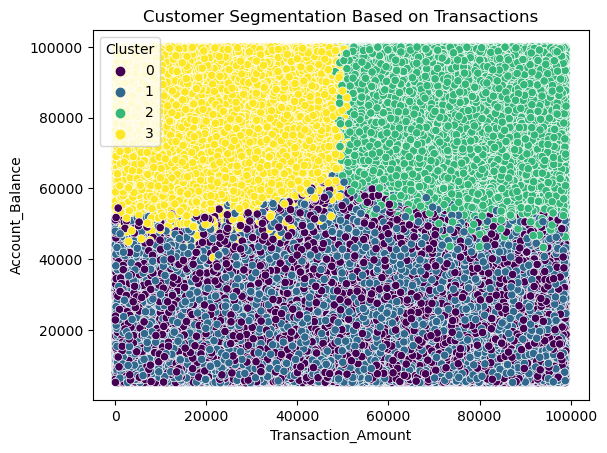

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="Transaction_Amount", y="Account_Balance", hue="Cluster", palette="viridis")
plt.title("Customer Segmentation Based on Transactions")
plt.show()


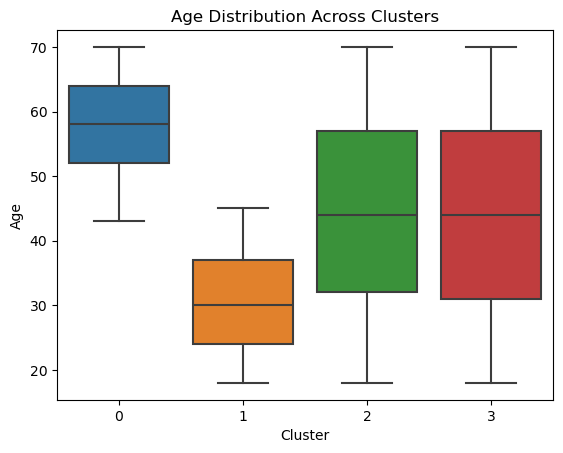

In [37]:
sns.boxplot(data=df, x="Cluster", y="Age")
plt.title("Age Distribution Across Clusters")
plt.show()


## Conclusion:  
*Although the dataset has been updated, I have confirmed that the informative columns remain identical to the previous version. Therefore, the analysis for this part remains unchanged from the old version, and I will not repeat it here.*